The purpose of this notebook is to evaluate the electron and photon IDs and determine the best way to handle potential overlaps. It borrows from some of the nice efficiency studies from Maria in the lj_reco_efficiency directory.

Logistics:

Need to study 2mu2e sample; copied part of Dongyub's yaml to this branch
For now, just studying the effects with the normal loose electron ID, not the loose ID minus n missing hits
Defined five new cuts, keeping all events but varying the photon ID definition:
- Loose photons
- Loose photons that also pass the electron conversion veto
- Loose photons that also pass the electron conversion veto or are far away from electrons
- Loose photons that also pass the pixel seed veto
- Loose photons that also pass the pixel seed veto or are far away from electrons

Current step: Check effect on efficiency (and invariant mass?) plots

In [2]:
# python
import sys
import os
import importlib
import numpy as np
# columnar analysis
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
from matplotlib.artist import Artist 
utilities.set_plot_style()
%matplotlib inline

In [3]:
samples = [
    '2mu2e_500GeV_5GeV_0p08mm',
    '2mu2e_500GeV_5GeV_0p8mm',
    '2mu2e_500GeV_5GeV_8p0mm',
    '2mu2e_500GeV_5GeV_40p0mm',
    '2mu2e_500GeV_5GeV_80p0mm'    
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2_merged")

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    # maxchunks=1,
)

p = sidm_processor.SidmProcessor(
    [
        "AllEvts_ElectronVetoPhotons", "AllEvts_ElectronVetoPhotonsOrIsoPhotons", 
        "AllEvts_PixelSeedPhotons", "AllEvts_PixelSeedPhotonsOrIsoPhotons",
        "AllEvts_AllLoosePhotons"
        #GED photons are iso photons passed the PF ID
    ],
    ["gen_base"],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
    verbose=False,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]


Output()

Output()

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered 
in divide
  result = getattr(ufunc, method)(

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_ElectronVetoPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_PixelSeedPhotonsOrIsoPhotons

Not applying any obj cuts after LJ clustering for channel AllEvts_AllLoosePhotons

# Funtions of Code

# Definitions

In [ ]:
ncol = 2
    
    #automatically calculates how many rows we need
    
    rows_per_sample = 2 * ((len(nums) + 1) // 2)
    nrow = len(samples)*rows_per_sample
    
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*15, nrow*9))
    axs_flat = axs.flatten()
    plt.tight_layout()
    subplotidx = 0
    
    
    nrow = 2
    
    NumUniquePlots = len(nums)*len(channels)
    
    
    if (NumUniquePlots%2) == 0:
        nrow = NumUniquePlots
    else:
        nrow = NumUniquePlots+1
        
    print(nrow, ncol)
    
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*15, nrow*9))
    axs_flat = axs.flatten()
    
    print(type(axs[0]))
    
    subplotidx = 0

In [7]:
def plotHists(nums, denoms, channels, errorBars=True, sample=samples[4]):
    if len(nums) != len(denoms):
        print("Need an even number of numerator and denominator histograms!")
        return
    
    ncol = 2
    
    #automatically calculates how many rows we need
    
    rows_per_sample = 2 * ((len(nums) + 1) // 2)
    nrow = len(samples)*rows_per_sample
    
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*15, nrow*9))
    axs_flat = axs.flatten()
    plt.tight_layout()
    subplotidx = 0
    
    for i, num in enumerate(nums): 
        denom = denoms[i]
        
        for channel in channels:
            num_hist =  out[sample]["hists"][num][channel,:]
            denom_hist =  out[sample]["hists"][denom][channel,:]

            # Calculate the efficiency and associated errors
            eff_hist, errors = utilities.get_eff_hist(num_hist, denom_hist)
    
            num_hist.plot1d(ax=axs_flat[subplotidx],label=num)
            denom_hist.plot1d(ax=axs_flat[subplotidx],label=denom)
            axs_flat[subplotidx].set_title(channel)
            axs_flat[subplotidx+2].set_title(channel)
            eff_hist.plot1d(ax=axs_flat[subplotidx+2],yerr=errors)
            subplotidx = subplotidx+1
            if (subplotidx %2)==0:
                subplotidx = subplotidx+2

In [5]:
def plotAllChannelperSamp(nums, denoms, channels, samples, errorBars=True,upperlim=400j):
    
    if len(nums) != len(denoms):
        print("Need the same number of numerator and denominator histograms!")
        return
    
    ncol = 2
    
    #automatically calculates how many rows we need
    
    rows_per_sample = 2 * ((len(nums) + 1) // 2)
    nrow = len(samples)*rows_per_sample
    
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*15, nrow*9))
    axs_flat = axs.flatten()
    plt.tight_layout()
    subplotidx = 0

    for j, sample in enumerate(samples):
        for i in range(len(nums)):
            
    # This is a fancy way to draw the plots in the right order
        
            subplotidx = j * rows_per_sample * ncol + 2 * (i // ncol) * ncol + (i % ncol)
            num = nums[i]
            denom = denoms[i]
            
    # Is the same for all channels so only needs to be plotted once
            denom_hist =  out[sample]["hists"][denom][channels[0], :upperlim]
            denom_hist.plot1d(ax=axs_flat[subplotidx],label=denom)
            for channel in channels:
                num_hist = out[sample]["hists"][num][channel, :upperlim]
               
    # Calculate the efficiency and associated errors
                eff_hist, errors = utilities.get_eff_hist(num_hist, denom_hist)
           
                
    # plotting num and denom hists
                num_hist.plot1d(ax=axs_flat[subplotidx],label= channel)
                
                axs_flat[subplotidx].set_ylabel("Number of Events")
                axs_flat[subplotidx].set_title(f"{num} - {sample}")
                axs_flat[subplotidx].legend()

    # plotting effiecencies
                axs_flat[subplotidx + ncol].set_title(f"Efficiency for Sample {sample}")
                eff_hist.plot1d(ax=axs_flat[subplotidx + ncol], yerr=errors, label=channel)
                axs_flat[subplotidx + ncol].set_ylabel("Efficiency")
                axs_flat[subplotidx + ncol].legend()
                

         

In [15]:
def plotStackedHists(nums, denom, channels, errorBars=True, sample=samples[4]):
    out = output["out"][sample]
    ncol = 1
    nrow = 2
       
    fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*20, nrow*10))
    plt.tight_layout()
    axs_flat = axs.flatten()
            
    for i, num in enumerate(nums): 
        denom_hist =  out["hists"][denom][channels[0],:]
        denom_hist.plot1d(ax=axs_flat[0],label=denom)
        
        for channel in channels:
            num_hist =  out["hists"][num][channel,:]

            # Calculate the efficiency and associated errors
            eff_hist, errors = utilities.get_eff_hist(num_hist, denom_hist)
    
            num_hist.plot1d(ax=axs_flat[0],label=channel)
            axs_flat[0].set_title(denom)
            axs_flat[0].set_ylabel("Number of Events")
            axs_flat[1].set_ylabel("Effiency")
            
        #plotstacked hists for multiple samples, agaisnts all channels. loop over all of the samples. create a subplotidx for plotstacked in order to get a subplot for each sample 
            
            #add a title for specific plots, maybe sample name
            #add a ylabel to the plots 
            axs_flat[1].set_title(channel) #let's chqange the title to sample name 
            eff_hist.plot1d(ax=axs_flat[1],yerr=errors, label=channel)
    axs_flat[1].legend()
    axs_flat[0].legend()

# One Channel for one Sample

Dark Photon Pt and Dark Photon Lx

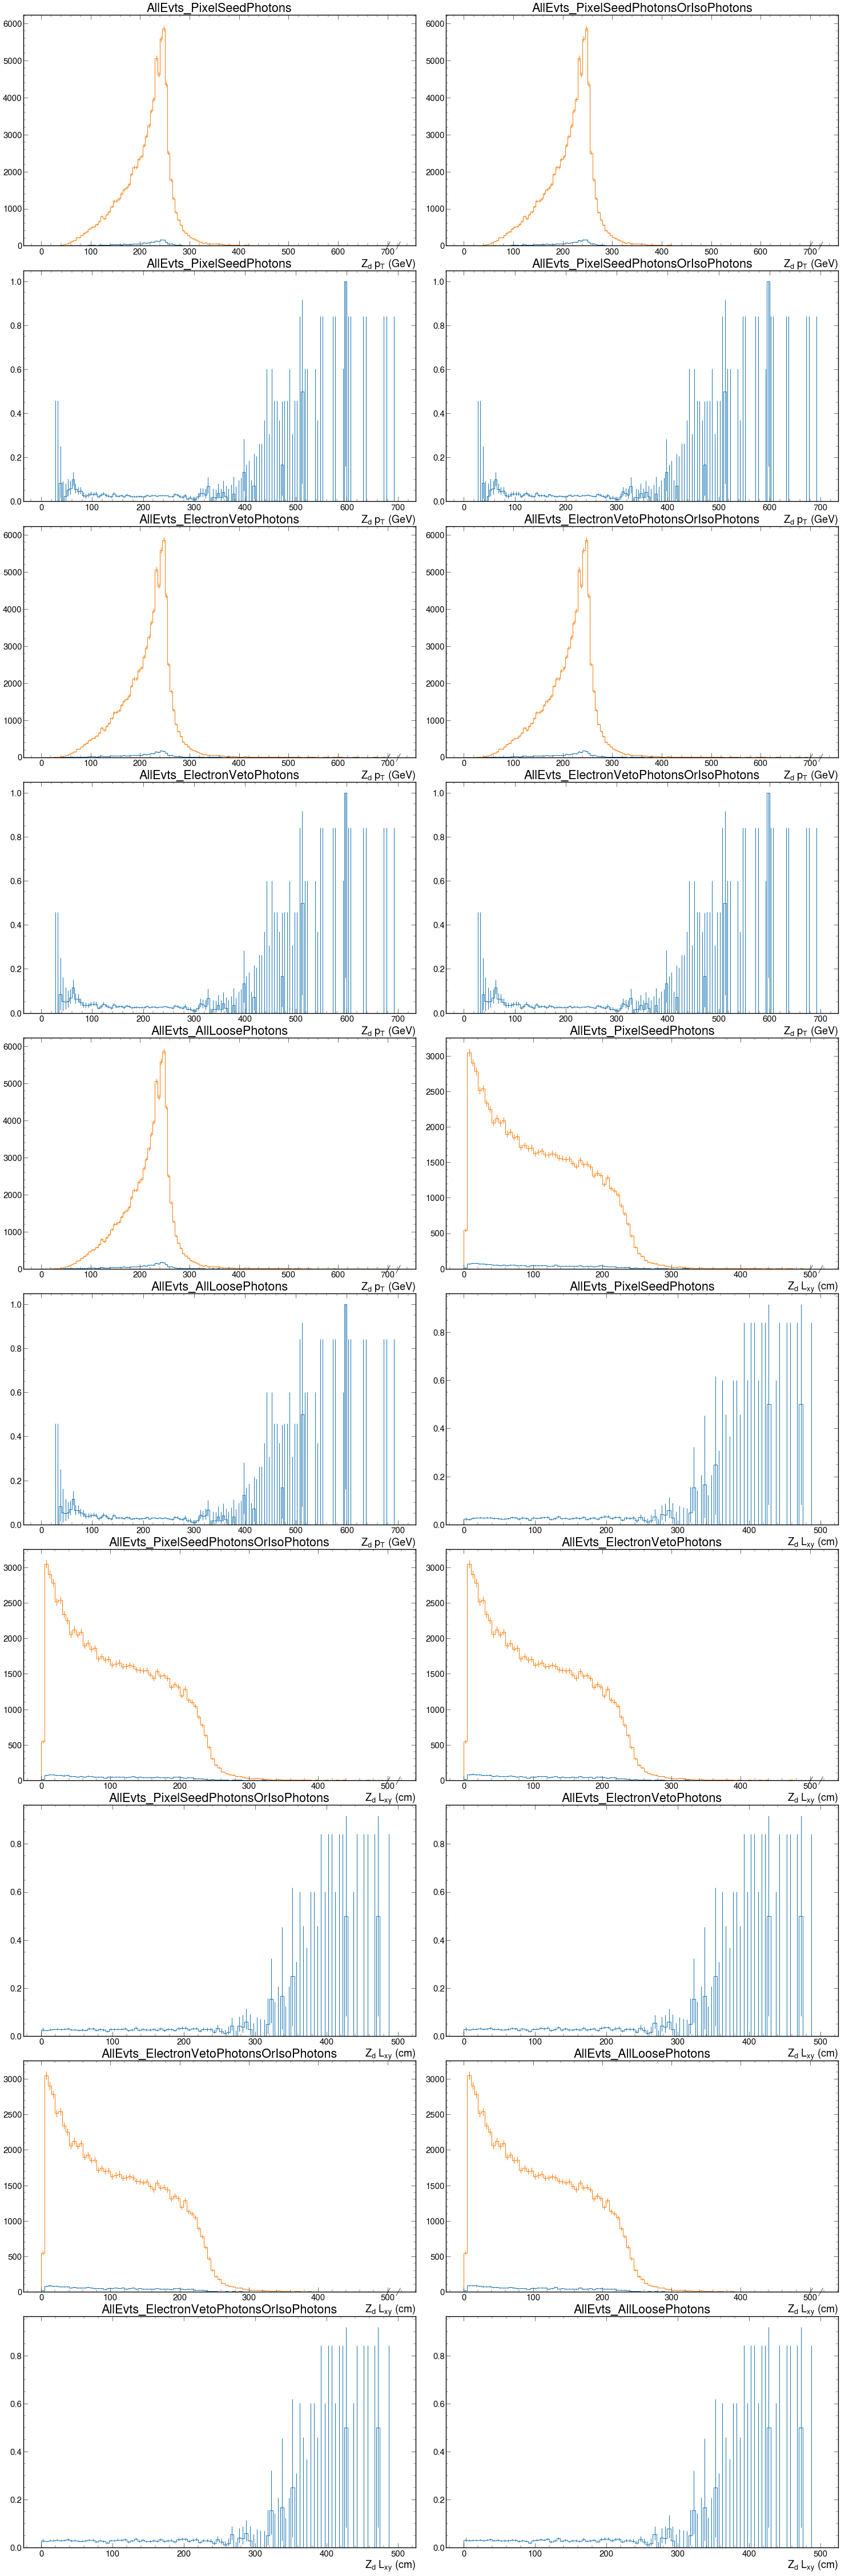

In [6]:
plotHists(["genA_toE_matched_egmLj_pt_highRange","genA_toE_matched_egmLj_lxy"], ["genAs_toE_pt_highRange","genAs_toE_lxy"], 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"], samples)

10 2
<class 'numpy.ndarray'>


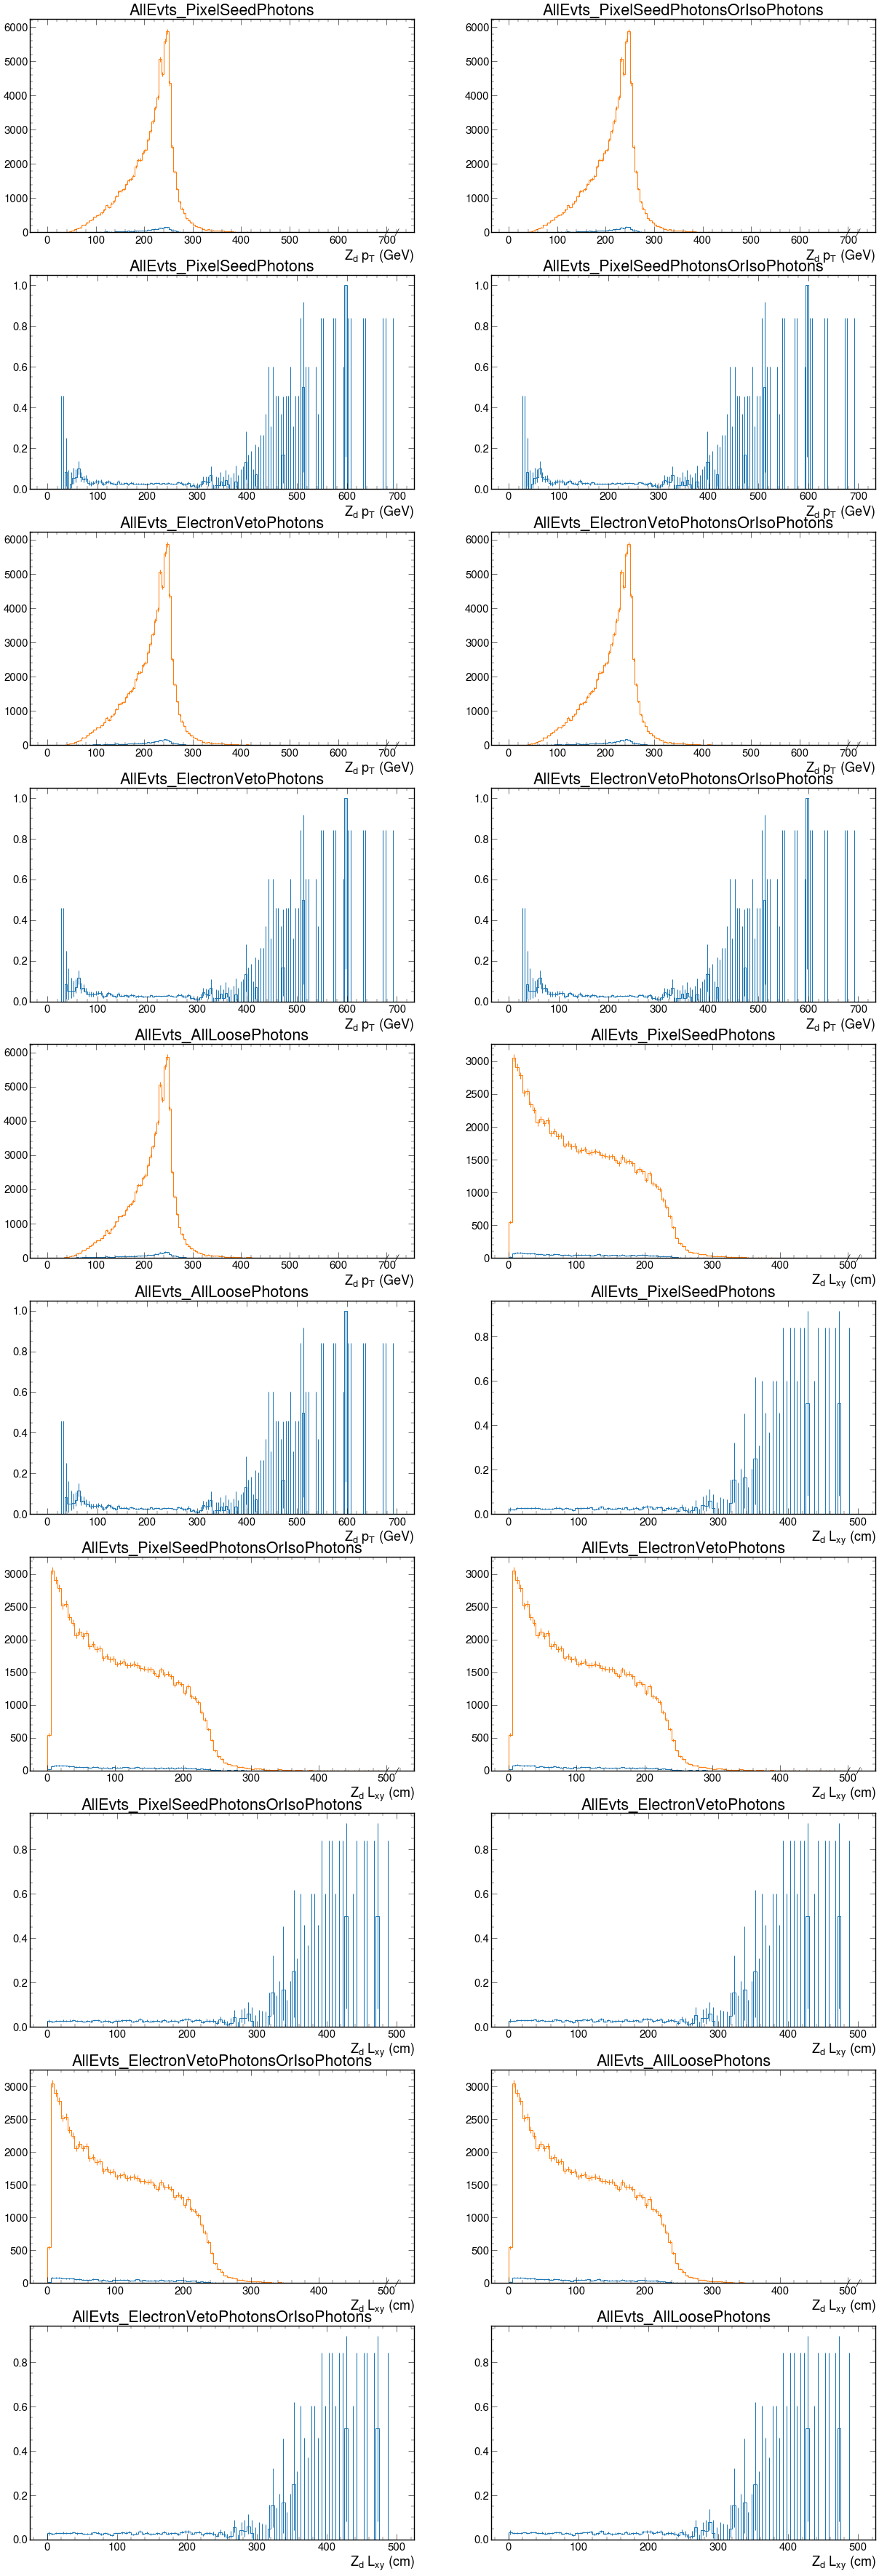

In [17]:
plotHists(["genA_toE_matched_egmLj_pt_highRange","genA_toE_matched_egmLj_lxy"], ["genAs_toE_pt_highRange","genAs_toE_lxy"], 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"], samples)

# All stacked Channels per Sample

Dark Photon Pt and Dark Photon Lxy

We are going to use this plot to compare the other profiles of the different channels using sample [3] (Pt/Lxy)

I think I just made plotstackedhists. Why are we plotting the num and the demon? Is this what we want to show? Are the labels correct?

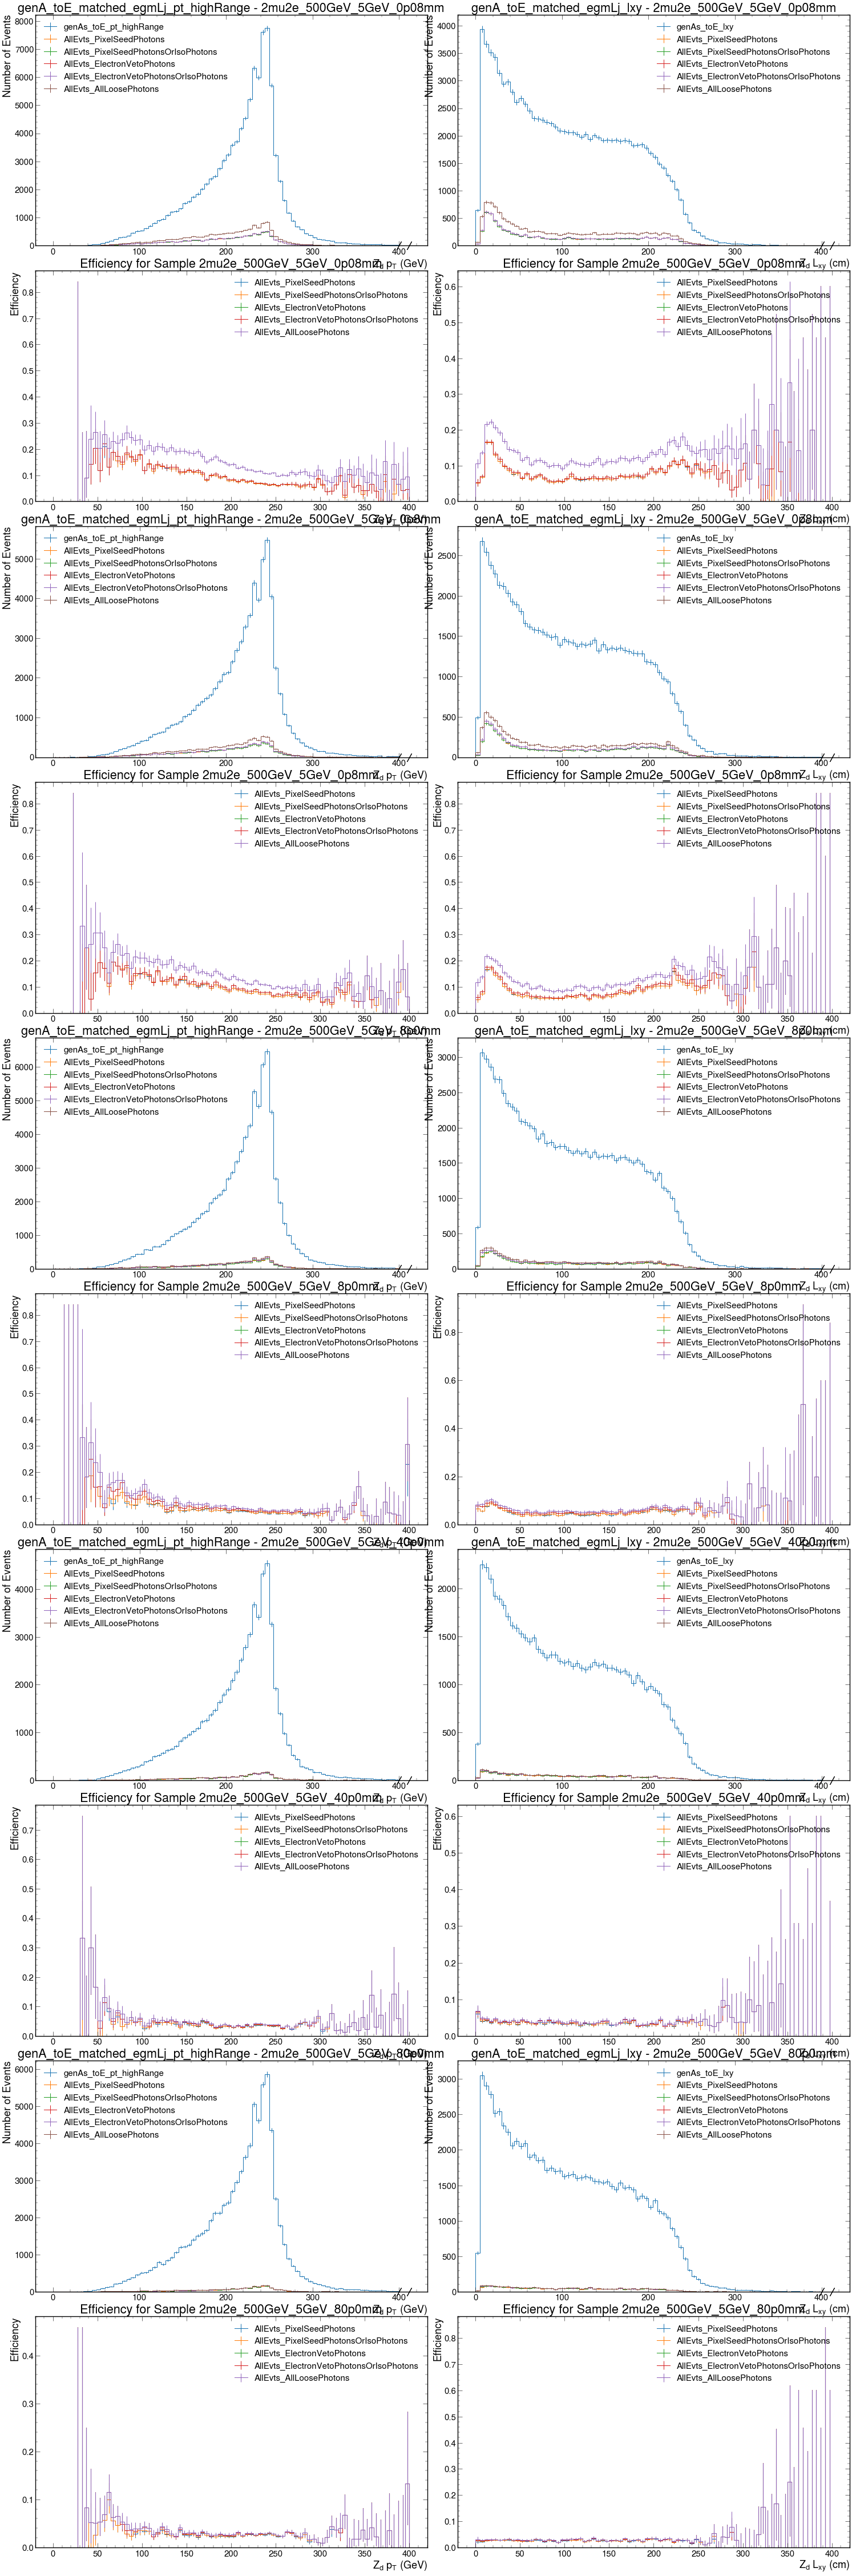

In [18]:
plotAllChannelperSamp(["genA_toE_matched_egmLj_pt_highRange","genA_toE_matched_egmLj_lxy"], ["genAs_toE_pt_highRange","genAs_toE_lxy"], 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"], samples, upperlim=400j)

# All stacked Channels for one Sample

Dark Photon Pt

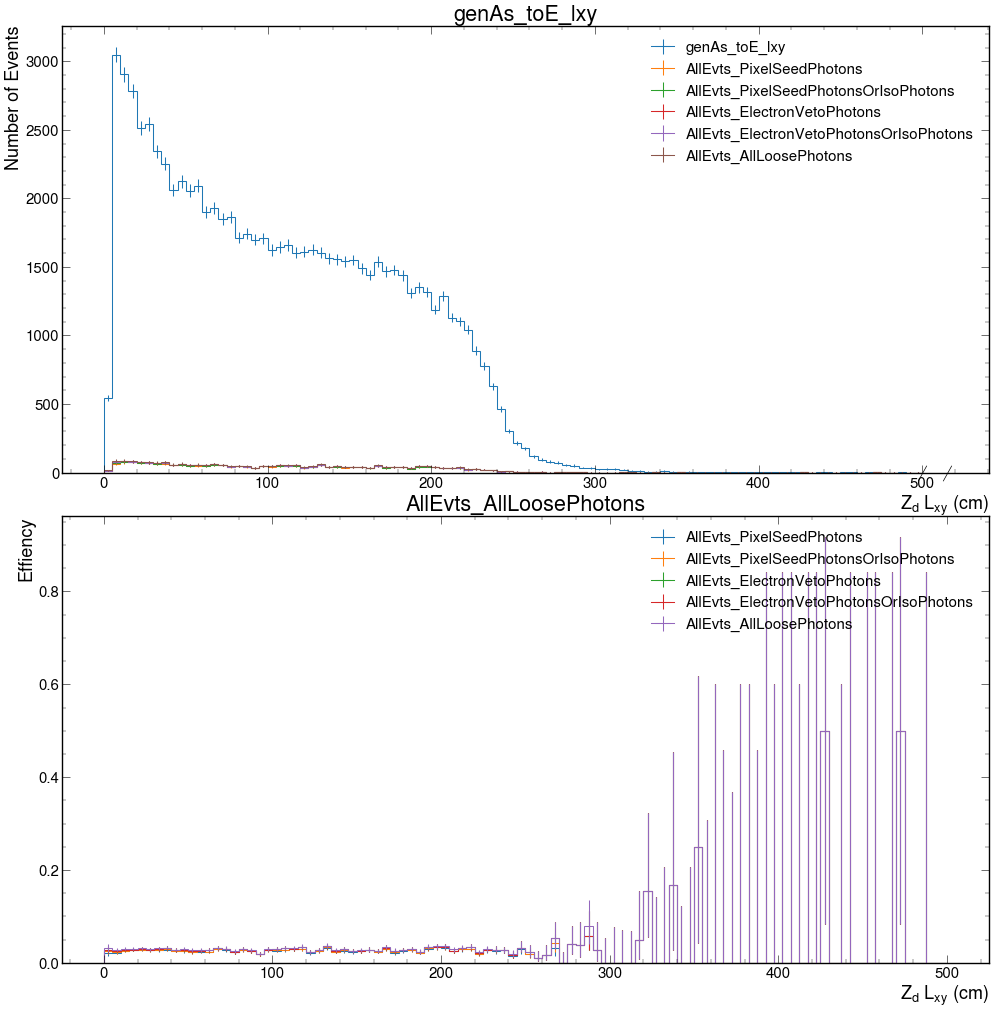

In [19]:
plotStackedHists(["genA_toE_matched_egmLj_lxy"], "genAs_toE_lxy", 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"])

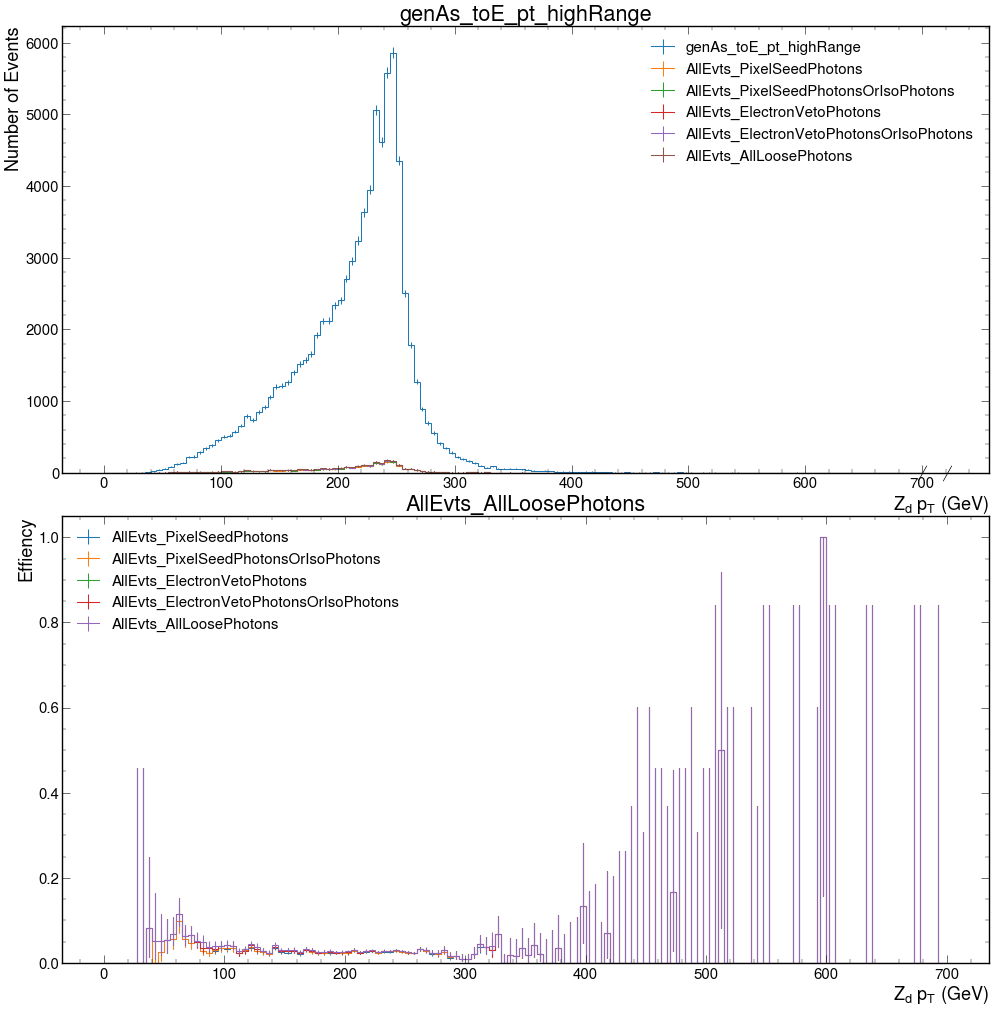

In [20]:
plotStackedHists(["genA_toE_matched_egmLj_pt_highRange"], "genAs_toE_pt_highRange", 
          ["AllEvts_PixelSeedPhotons","AllEvts_PixelSeedPhotonsOrIsoPhotons",
           "AllEvts_ElectronVetoPhotons","AllEvts_ElectronVetoPhotonsOrIsoPhotons",
          "AllEvts_AllLoosePhotons"])

# Subplotidx Figurations

In [21]:
subplotidx = 0
for num in range (1,2):
    for sample in range (1,3):
        for channel in range (1,6):
            print (num, sample, channel)
    subplotidx = subplotidx+1
    if (subplotidx %2)==0:
        subplotidx = subplotidx+2      
    print ("newidx = ", subplotidx)

1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
newidx =  1


In [22]:
subplotidx = 0
for i, sample in enumerate(samples):
    for num in range (0,2):
        for channel in range (1,6):
            print (num, sample, channel)
        subplotidx = subplotidx+1
        if (subplotidx %2)==0:
            subplotidx = subplotidx+2      
        print ("newidx = ", subplotidx)

0 2mu2e_500GeV_5GeV_0p08mm 1
0 2mu2e_500GeV_5GeV_0p08mm 2
0 2mu2e_500GeV_5GeV_0p08mm 3
0 2mu2e_500GeV_5GeV_0p08mm 4
0 2mu2e_500GeV_5GeV_0p08mm 5
newidx =  1
1 2mu2e_500GeV_5GeV_0p08mm 1
1 2mu2e_500GeV_5GeV_0p08mm 2
1 2mu2e_500GeV_5GeV_0p08mm 3
1 2mu2e_500GeV_5GeV_0p08mm 4
1 2mu2e_500GeV_5GeV_0p08mm 5
newidx =  4
0 2mu2e_500GeV_5GeV_0p8mm 1
0 2mu2e_500GeV_5GeV_0p8mm 2
0 2mu2e_500GeV_5GeV_0p8mm 3
0 2mu2e_500GeV_5GeV_0p8mm 4
0 2mu2e_500GeV_5GeV_0p8mm 5
newidx =  5
1 2mu2e_500GeV_5GeV_0p8mm 1
1 2mu2e_500GeV_5GeV_0p8mm 2
1 2mu2e_500GeV_5GeV_0p8mm 3
1 2mu2e_500GeV_5GeV_0p8mm 4
1 2mu2e_500GeV_5GeV_0p8mm 5
newidx =  8
0 2mu2e_500GeV_5GeV_8p0mm 1
0 2mu2e_500GeV_5GeV_8p0mm 2
0 2mu2e_500GeV_5GeV_8p0mm 3
0 2mu2e_500GeV_5GeV_8p0mm 4
0 2mu2e_500GeV_5GeV_8p0mm 5
newidx =  9
1 2mu2e_500GeV_5GeV_8p0mm 1
1 2mu2e_500GeV_5GeV_8p0mm 2
1 2mu2e_500GeV_5GeV_8p0mm 3
1 2mu2e_500GeV_5GeV_8p0mm 4
1 2mu2e_500GeV_5GeV_8p0mm 5
newidx =  12
0 2mu2e_500GeV_5GeV_40p0mm 1
0 2mu2e_500GeV_5GeV_40p0mm 2
0 2mu2e_500GeV_5GeV